In [1]:
import torch
from torch_geometric.data import Data
import pandas as pd
import numpy as np
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.nn import MSELoss
import matplotlib.pyplot as plt

In [13]:
df = pd.read_csv('../../Datasets/Lynx_Hare/data.csv', usecols=['DATE', 'HARE', 'LYNX'])
print(df)

scaler = StandardScaler()
df[['HARE', 'LYNX']] = scaler.fit_transform(df[['HARE', 'LYNX']])

# features = torch.tensor(df[['HARE', 'LYNX']].values, dtype=torch.float)
# print(features)

# Create lagged features for one-step ahead prediction
df['HARE_lag1'] = df['HARE'].shift(1)
df['LYNX_lag1'] = df['LYNX'].shift(1)

# Remove the last row to avoid NaN values
df.dropna(inplace=True)

# Define features (x) and targets (y)
x = df[['HARE_lag1', 'LYNX_lag1']].values  # previous time step's data as input
y = df[['HARE', 'LYNX']].values  
print(df)

    DATE   HARE   LYNX
0   1845  19.58  30.09
1   1846  19.60  45.15
2   1847  19.61  49.15
3   1848  11.99  39.52
4   1849  28.04  21.23
..   ...    ...    ...
86  1931  19.52   8.31
87  1932  82.11  16.01
88  1933  89.76  24.82
89  1934  81.66  29.70
90  1935  15.76  35.40

[91 rows x 3 columns]
    DATE      HARE      LYNX  HARE_lag1  LYNX_lag1
1   1846 -0.713379  0.896212  -0.713932   0.093463
2   1847 -0.713103  1.109426  -0.713379   0.896212
3   1848 -0.923746  0.596114  -0.713103   1.109426
4   1849 -0.480069 -0.378806  -0.923746   0.596114
5   1850  0.348128 -1.061622  -0.480069  -0.378806
..   ...       ...       ...        ...        ...
86  1931 -0.715591 -1.067486  -1.138258  -1.138379
87  1932  1.014610 -0.657049  -0.715591  -1.067486
88  1933  1.226082 -0.187446   1.014610  -0.657049
89  1934  1.002171  0.072674   1.226082  -0.187446
90  1935 -0.819530  0.376504   1.002171   0.072674

[90 rows x 5 columns]


In [7]:
# Sequential split for training and testing
split_idx = int(len(x) * 0.8)
x_train, x_test = x[:split_idx], x[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float)
x_test = torch.tensor(x_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

In [8]:
edge_index = torch.tensor([[0], [1]], dtype=torch.long)  # Lynx -> Hare
# x = features
# data = Data(x=x, edge_index=edge_index)
data_train = Data(x=x_train, edge_index=edge_index)
data_test = Data(x=x_test, edge_index=edge_index)

In [9]:
# Model Implementation
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(2, 16)
        self.conv2 = GCNConv(16, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

model = GNN()

In [10]:
optimizer = Adam(model.parameters(), lr=0.01)
criterion = MSELoss()

# y = features  
# print(x)
# print(y)
# # Split the data into training and testing sets
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# data_train = Data(x=x_train, edge_index=edge_index)
# data_test = Data(x=x_test, edge_index=edge_index)

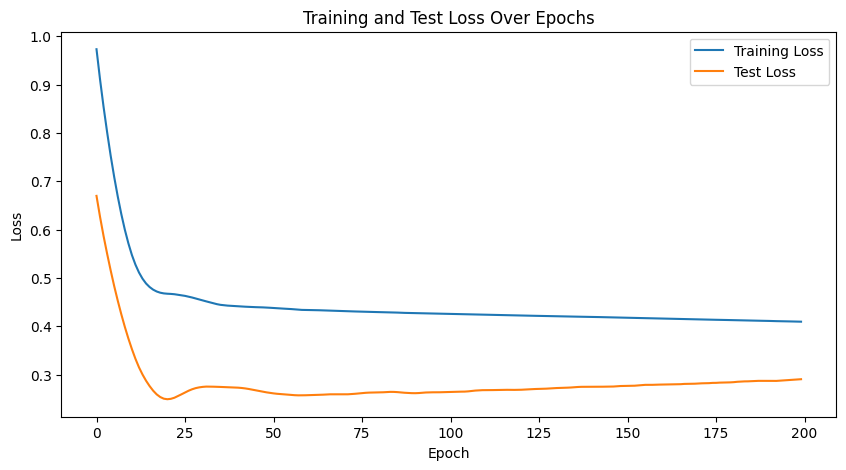

Final Test MSE: 0.2905999422073364


In [11]:
train_losses = []
test_losses = []

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data_train)
    train_loss = criterion(out, y_train)
    train_loss.backward()
    optimizer.step()
    
    model.eval()  
    with torch.no_grad(): # gradient is not computed
        test_pred = model(data_test)
        test_loss = criterion(test_pred, y_test)
    
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())

# training and testing losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

model.eval() 
with torch.no_grad(): 
    final_pred = model(data_test)
    final_mse_test = criterion(final_pred, y_test)

print(f'Final Test MSE: {final_mse_test.item()}')

In [7]:
df = pd.read_csv('../../Datasets/study_373/top_5_373.csv', usecols=['DATE', '46670', '46982', '46504', '46571', '46888'])
print(df)
"""
46670  [Nyctereutes procyonoides]     Common Raccoon Dog      -> Rodents, Japanese Hare
46982  [Sus scrofa]				      Wild Boar               -> Rodents, Japanese Hare
46504  [Lepus brachyurus]			  Japanese Hare
46571  [Meles anakuma]			      Japanese Badger         -> Rodents
46888  [Rodentia]
"""

scaler = StandardScaler()
df[['46670', '46982', '46504', '46571', '46888']] = scaler.fit_transform(df[['46670', '46982', '46504', '46571', '46888']])

features = torch.tensor(df[['46670', '46982', '46504', '46571', '46888']].values, dtype=torch.float)
print(features)

           DATE  46670  46982  46504  46571  46888
0    2008-06-08    1.0    2.0    1.0    1.0    2.0
1    2008-07-11    1.0    3.0    1.0    1.0    2.0
2    2008-09-14    2.0    6.0    2.0    1.0    1.0
3    2008-09-16    2.0    1.0    1.0    1.0    3.0
4    2008-09-22    2.0    4.0    1.0    1.0    2.0
..          ...    ...    ...    ...    ...    ...
388  2012-10-18   10.0    6.0    1.0    1.0    2.0
389  2012-10-22    8.0    6.0    1.0    1.0    3.0
390  2012-10-28    3.0    1.0    1.0    1.0    2.0
391  2012-11-08    2.0    7.0    1.0    1.0    2.0
392  2012-11-09    2.0    1.0    1.0    1.0    1.0

[393 rows x 6 columns]
tensor([[-1.2573, -0.8466, -0.9254, -1.0098, -0.3033],
        [-1.2573, -0.6576, -0.9254, -1.0098, -0.3033],
        [-1.0486, -0.0904, -0.4878, -1.0098, -0.7654],
        ...,
        [-0.8400, -1.0357, -0.9254, -1.0098, -0.3033],
        [-1.0486,  0.0986, -0.9254, -1.0098, -0.3033],
        [-1.0486, -1.0357, -0.9254, -1.0098, -0.7654]])


In [8]:
edge_index = torch.tensor([
    [0, 0, 3, 3, 4],  # Predators: 46670 (Index 0), 46982 (Index 3), 46571 (Index 4)
    [1, 2, 1, 2, 1]   # Prey: 46888 (Index 1), 46504 (Index 2)
], dtype=torch.long)
x = features
data = Data(x=x, edge_index=edge_index)

In [9]:
# Model Implementation
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(5, 16)
        self.conv2 = GCNConv(16, 5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

model = GNN()

In [10]:
optimizer = Adam(model.parameters(), lr=0.01)
criterion = MSELoss()

y = features  
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

data_train = Data(x=x_train, edge_index=edge_index)
data_test = Data(x=x_test, edge_index=edge_index)

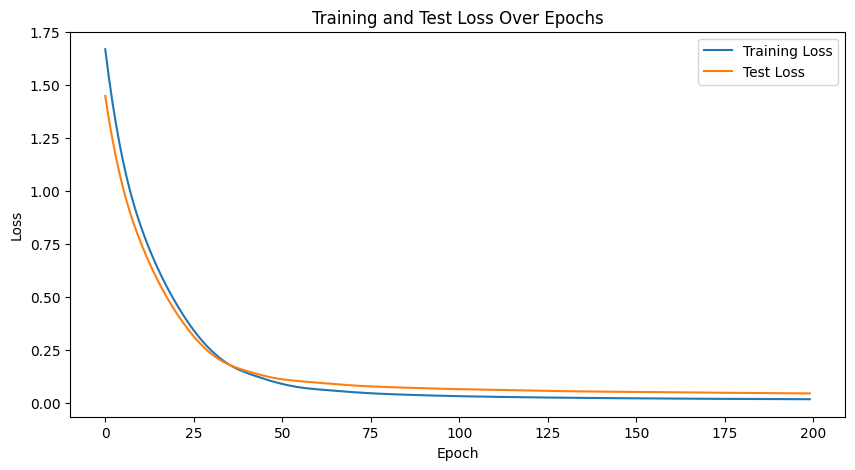

Final Test MSE: 0.04408130422234535


In [11]:
train_losses = []
test_losses = []

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data_train)
    train_loss = criterion(out, y_train)
    train_loss.backward()
    optimizer.step()
    
    model.eval()  
    with torch.no_grad(): # gradient is not computed
        test_pred = model(data_test)
        test_loss = criterion(test_pred, y_test)
    
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())

# training and testing losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

model.eval() 
with torch.no_grad(): 
    final_pred = model(data_test)
    final_mse_test = criterion(final_pred, y_test)

print(f'Final Test MSE: {final_mse_test.item()}')

In [12]:
df = pd.read_csv('../../Datasets/study_213/top_5_213.csv', usecols=['DATE', '7058', '8572', '39601', '8901', '7730'])
print(df)
"""
7058 ['Merluccius bilinearis']  Silver hake             -> Silver hake, Spiny dogfish, Longfin inshore squid, Red hake, American butterfish
8572 ['Squalus acanthias']      Spiny dogfish           -> Silver hake, Spiny dogfish, Longfin inshore squid, Red hake, American butterfish
39601 ['Doryteuthis pealeii']   Longfin inshore squid   -> Silver hake, Longfin inshore squid
8901 ['Urophycis chuss']        Red hake                -> Silver hake, Longfin inshore squid, Red hake, American butterfish
7730 ['Peprilus triacanthus']   American butterfish     -> Longfin inshore squid
"""

scaler = StandardScaler()
df[['7058', '8572', '39601', '8901', '7730']] = scaler.fit_transform(df[['7058', '8572', '39601', '8901', '7730']])

features = torch.tensor(df[['7058', '8572', '39601', '8901', '7730']].values, dtype=torch.float)
print(features)

            DATE    7058   8572  39601   8901   7730
0     1963-11-14  1531.0  422.0   19.0  164.0    2.0
1     1963-12-10   437.0   94.0   17.0   97.0    1.0
2     1964-10-25   189.0   66.0   36.0   23.0  761.0
3     1964-10-29   370.0  116.0   83.0  196.0  561.0
4     1964-12-04   101.0    5.0   21.0  233.0    2.0
...          ...     ...    ...    ...    ...    ...
1510  2008-10-28   255.0   16.0  185.0   44.0   15.0
1511  2008-10-30   741.0  735.0  252.0   87.0  382.0
1512  2008-11-03   287.0  291.0   14.0   16.0    1.0
1513  2008-11-04   732.0  468.0   32.0  186.0    1.0
1514  2008-11-08    78.0    3.0  471.0    1.0   14.0

[1515 rows x 6 columns]
tensor([[ 1.5018, -0.2359, -0.5509,  0.1091, -0.3401],
        [ 0.0341, -0.4660, -0.5514, -0.1317, -0.3404],
        [-0.2987, -0.4857, -0.5467, -0.3977, -0.1342],
        ...,
        [-0.1672, -0.3278, -0.5521, -0.4229, -0.3404],
        [ 0.4298, -0.2036, -0.5477,  0.1882, -0.3404],
        [-0.4476, -0.5299, -0.4397, -0.4768, -0.336

In [13]:
edge_index = torch.tensor([
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 4],  
    [0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 2, 0, 2, 3, 4, 2]   
], dtype=torch.long)
x = features
data = Data(x=x, edge_index=edge_index)

In [17]:
# Model Implementation
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(5, 16)
        self.conv2 = GCNConv(16, 5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

model = GNN()

In [18]:
optimizer = Adam(model.parameters(), lr=0.01)
criterion = MSELoss()

y = features  
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

data_train = Data(x=x_train, edge_index=edge_index)
data_test = Data(x=x_test, edge_index=edge_index)

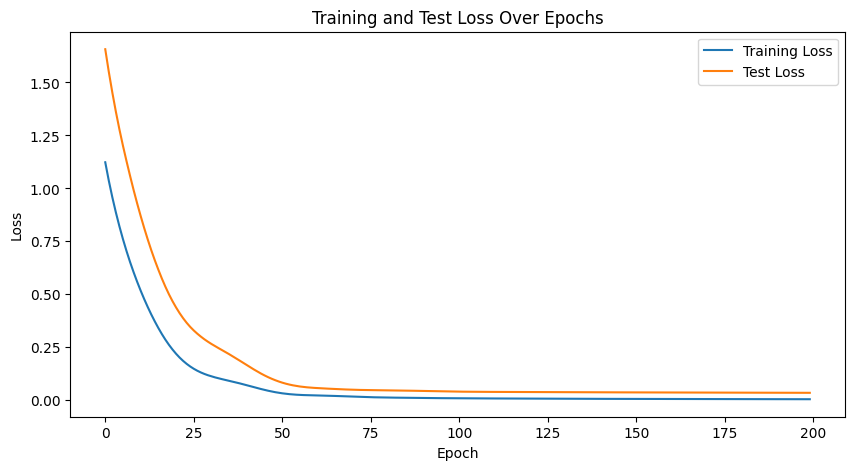

Final Test MSE: 0.03508487716317177


In [19]:
train_losses = []
test_losses = []

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data_train)
    train_loss = criterion(out, y_train)
    train_loss.backward()
    optimizer.step()
    
    model.eval()  
    with torch.no_grad(): # gradient is not computed
        test_pred = model(data_test)
        test_loss = criterion(test_pred, y_test)
    
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())

# training and testing losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

model.eval() 
with torch.no_grad(): 
    final_pred = model(data_test)
    final_mse_test = criterion(final_pred, y_test)

print(f'Final Test MSE: {final_mse_test.item()}')